In [1533]:
from matplotlib import rcParams

rcParams["figure.dpi"] = 300

import matplotlib.pyplot as plt

plt.rcParams["axes.facecolor"] = "white"

from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter, MultipleLocator

import numpy as np

import math

# Pg. 51, (3.1)
kn_to_ft_per_second = 1.6878


def engine_torque(power, propeller_rps):
    """Engine torque :math:`M` depends on the following formula:

    :math:`M = P / 2\pin`

    Args:
        power: :math:`P`, power in ft-lbf/s.
        propeller_rps: :math:`n`, propeller revolutions per second.

    Returns:
        :math:`M`, engine torque in ft-lbf.
    """
    return power / 2 * math.pi * propeller_rps


class DataPlate:
    # S, reference wing area (ft^2).
    reference_wing_area = 174
    # A, wing aspect ratio (span^2/S).
    wing_span = 36
    wing_aspect_ratio = wing_span ** 2 / reference_wing_area
    # C_{D0}, parasite drag coefficient (depends on flaps/gear configuration).
    parasite_drag_coefficient = 0.02874
    # e, airplane efficiency factor (possibly depends on flaps configuration).
    airplane_efficiency_factor = 0.7200

    # M_0, rated full-throttle engine torque (ft-lbf)
    rated_full_throttle_engine_horsepower = 235
    # $P_0$, rated MSL power (ft-lbf/sec)
    rated_full_throttle_engine_power = rated_full_throttle_engine_horsepower * 550
    rated_full_throttle_engine_rpm = 2400
    rated_full_throttle_propeller_rps = rated_full_throttle_engine_rpm / 60
    # $M_B$, base MSL-rated torque at full throttle.
    rated_full_throttle_engine_torque = engine_torque(
        rated_full_throttle_engine_power, rated_full_throttle_propeller_rps
    )

    # C, engine power altitude dropoff parameter, the porportion of indicated
    # power that goes to engine friction losses (close to 0.12).
    engine_power_altitude_dropoff_parameter = 0.12
    # d, propeller diameter (ft).
    propeller_diameter = 6.83
    # TAF total activity factor
    blade_activity_factor = 97.95
    total_activity_factor = blade_activity_factor * 2
    # Z, ratio of fuselage diameter (taken one propeller diameter behind the
    # propeller) to propeller diameter.
    z_ratio = 0.688


def relative_atmospheric_density(atmospheric_density, msl_standard_density=0.002377):
    """Calculate relative atmospheric density with :math`ρ`.

    Args:
        atmospheric_density:
            :math`ρ`, atmospheric density in slug/ft^3.
        msl_standard_density:
            MSL standard density :math:`ρ_0 = 0.002377` slug/ft^3 (Optional).

    Returns:
        relative_atmospheric_density: :math:`σ`, relative atmospheric density.
    """
    return atmospheric_density / msl_standard_density


def relative_atmospheric_density_alt(oat_f, pressure_altitude):
    """Calculate relative atmospheric density with :math:`h_p` and
    :math:`{OAT_{\degree{F}}}`.

    Args:
        oat_f:
            :math:`{OAT_{\degree{F}}}`, outside air temperature in degrees
            Fahrenheit.
        pressure_altitude:
            :math:`h_p`, pressure altitude.

    Returns:
        relative_atmospheric_density: :math:`σ`, relative atmospheric density.
    """
    # From Pg. 1 of TBA Field Guide.
    return (518.7 / (oat_f + 459.7)) * (
        1 - 6.8749 * 10 ** -6 * pressure_altitude
    ) ** 5.25625


def atmospheric_density(relative_atmospheric_density, msl_standard_density=0.002377):
    """Convert relative atmospheric density :math:`σ` to atmospheric density :math`ρ`.

    Args:
        relative_atmospheric_density:
            :math:`σ`, relative atmospheric density.
        msl_standard_density:
            MSL standard density :math:`ρ_0 = 0.002377` slug/ft^3 (Optional).

    Returns:
        atmospheric_density: :math`ρ`, atmospheric density in slug/ft^3.
    """
    return relative_atmospheric_density * msl_standard_density


# TBA Field Guide Pg. 1
assert math.isclose(
    atmospheric_density(0.88808),
    0.002111,
    # of 4 significant digits
    abs_tol=10 ** -6,
)


def altitude_power_dropoff_factor(relative_atmospheric_density):
    """Determine engine torque/power dropoff factor :math:`\phi`.

    Args:
        relative_atmospheric_density:
            :math:`\sigma`, relative atmospheric density.

    Returns:
        :math:`\phi`, engine torque/power dropoff factor.
    """
    return (
        relative_atmospheric_density - DataPlate.engine_power_altitude_dropoff_parameter
    ) / (1 - DataPlate.engine_power_altitude_dropoff_parameter)


# Compared against the Lycoming Operator's Manual for the O-540-J35AD
assert math.isclose(
    altitude_power_dropoff_factor(relative_atmospheric_density_alt(59, 0)) * 235,
    235,
    # of 0 significant digits
    abs_tol=10 ** -0,
)
assert math.isclose(
    altitude_power_dropoff_factor(relative_atmospheric_density_alt(-4, 17500)) * 235,
    122,
    # of 0 significant digits
    abs_tol=10 ** -0,
)


def c_to_f(c):
    """Convert Celcius to Fahrenheit."""
    return c * (9 / 5) + 32


def f_to_c(f):
    """Convert Fahrenheit to Celcius."""
    return (f - 32) * 5 / 9


def t_isa(pressure_altitude):
    """Get ISA temperature :math:`T` in °C for :math:`h_p`."""
    return 15 - 1.98 * (pressure_altitude / 1000)


def density_altitude(pressure_altitude, oat_f):
    """Get density altitude :math:`h_ρ` from :math:`h_p` and OAT°F."""
    return (f_to_c(oat_f) - t_isa(pressure_altitude)) * 118.8 + pressure_altitude


class OperationalParameters:
    gross_aircraft_weight = 3100

    pressure_altitude = 16000
    oat_f = 1.9

    relative_atmospheric_density = (1 - density_altitude(pressure_altitude, oat_f) / 145457) ** 4.25635
    atmospheric_density = atmospheric_density(relative_atmospheric_density)

    # engine_rpm = 2300
    # power = DataPlate.rated_full_throttle_engine_power * 0.65
    engine_rpm = DataPlate.rated_full_throttle_engine_rpm
    power = DataPlate.rated_full_throttle_engine_power * altitude_power_dropoff_factor(
        relative_atmospheric_density
    )
    propeller_rps = engine_rpm / 60


def bootstrap_power_setting_parameter(
    engine_torque, altitude_power_dropoff_factor, base_engine_torque
):
    """Determine bootstrap power-setting parameter, Π.

    Args:
        engine_torque: :math:`M`, engine torque in ft-lbf.
        altitude_power_dropoff_factor: :math:`\phi`, engine torque/power dropoff factor.
        base_engine_torque: :math:`M_B`, base MSL-rated torque at full throttle in ft-lbf.

    Returns:
        :math:`Π`, bootstrap power-setting parameter.
    """
    return engine_torque / (altitude_power_dropoff_factor * base_engine_torque)


def sdef_t(z_ratio):
    """Slowdown efficiency factor for the tractor propeller :math:`{SDEF}_T` was
    adapted from the 1936 graphs made by Walter Stuart Diehl from British and
    American experiments.

    Args:
        z_ratio: :math:`Z`, ratio of fuselage diameter to propeller diameter.

    Returns:
        :math:`{SDEF}`, slowdown efficiency factor for the tractor propeller.
    """
    return 1.05263 - 0.00722 * z_ratio - 0.16462 * z_ratio ** 2 - 0.18341 * z_ratio ** 3


# From Dr. Lowry's bootstp2.xls example.
assert math.isclose(
    sdef_t(0.688),
    0.910,
    # of 3 significant digits
    abs_tol=10 ** -3,
)


def propeller_advance_ratio(air_speed, propeller_rps, propeller_diameter):
    """Propeller advance ratio :math:`J` depends on the following formula:

    :math:`J = V/nd`

    Args:
        air_speed: Air speed in ft/sec.
        propeller_rps: :math:`n`, propeller revolutions per second.
        propeller_diameter: propeller diameter in ft.

    Returns:
        :math:`J`, propeller advance ratio.
    """
    return air_speed / (propeller_rps * propeller_diameter)


# Pg. 178, Example 6.4
assert math.isclose(
    propeller_advance_ratio(253.2, 2400 / 60, 7),
    0.9043,
    # of 4 significant digits
    abs_tol=10 ** -4,
)


def propeller_power_coefficient(
    power, atmospheric_density, propeller_rps, propeller_diameter
):
    """Propeller power coefficient :math:`C_P` depends on the following formula:

    :math:`C_P = P/\\rhon^3d^5`

    Args:
        power: :math:`P`, power in ft-lbf/s.
        atmospheric_density: :math:`\\rho`, atmospheric density in slug/ft^3.
        propeller_rps: :math:`n`, propeller revolutions per second.
        propeller_diameter: propeller diameter in ft.

    Returns:
        :math:`C_P`, propeller power coefficient.
    """
    return power / (
        atmospheric_density * (propeller_rps ** 3) * (propeller_diameter ** 5)
    )


# Pg. 178, Example 6.4
assert math.isclose(
    propeller_power_coefficient(200 * 550, 0.002048, 2400 / 60, 7),
    0.04993,
    # of 5 significant digits
    abs_tol=10 ** -5,
)


def power_adjustment_factor_x(total_activity_factor):
    """Power adjusment factor :math:`X` for your propeller depends on its TAF
    according to the (curve-fit) formula:

    :math:`X = 0.001515 {TAF} - 0.0880`

    Args:
        total_activity_factor:
            :math:`{TAF}`, the propeller total activity factor.

    Returns:
        :math:`X`, power adjustment factor.
    """
    return 0.001515 * total_activity_factor - 0.088


# From Dr. Lowry's bootstp2.xls example.
assert math.isclose(
    power_adjustment_factor_x(195.9),
    0.2088,
    # of 4 significant digits
    abs_tol=10 ** -4,
)


In [1534]:
# Dr. Lowry states:
# > Data and measurements for a general aviation constant-speed propeller let us
# > construct such a chart (see Fig. 6.19).
# This object is a representation of the coefficients that form Dr. Lowry's
# chart.
propeller_chart = {
    0.15: [
        -0.0272805419249278,
        1.15781894222425,
        -0.548923123012512,
        0.0385516502694899,
        0.064580555280077,
        -0.0263012433108758,
        0.00301741988065448,
    ],
    0.25: [
        -0.0385029968953664,
        1.04613581578757,
        -0.485313329667262,
        0.130100232509281,
        -0.0273266101237454,
        0.00313901396067647,
        -0.000131566344754572,
    ],
    0.40: [
        -0.026741905,
        0.7175824135,
        -0.08467335,
        -0.07445168,
        0.026437051,
        -0.003537565,
        0.000177733,
    ],
    0.60: [
        0.0381002521517944,
        0.199522455590403,
        0.458898025445346,
        -0.3189927366795,
        0.0813578214054723,
        -0.00908380171181081,
        0.000350613125807782,
    ],
    0.80: [
        0.251897476,
        -0.56166584,
        1.13905513,
        -0.60219333,
        0.144341736,
        -0.01619473,
        0.000664038,
    ],
    1.00: [
        0.140144145675375,
        0.0716361297937569,
        -0.0573564176265628,
        0.276378945894403,
        -0.159843307010587,
        0.0342398462584903,
        -0.00257300278564554,
    ],
    1.20: [
        -0.705604050000001,
        2.868232531,
        -3.651371295,
        2.487262933,
        -0.863421200000001,
        0.1464783315,
        -0.00968685500000001,
    ],
    1.40: [
        -2.34053218393923,
        7.56393789714959,
        -9.02096499247491,
        5.55004513329438,
        -1.79377691748934,
        0.291020480453595,
        -0.0187431693125258,
    ],
}


def propeller_efficiency(
    z_ratio,
    propeller_advance_ratio,
    propeller_power_coefficient,
    power_adjustment_factor_x,
):
    """Approximates η, constant-speed propulsive efficiency:

    :math:`\eta = {SDEF(Z)} \\times \eta(J/C_p{}^\\frac{1}{3}{}^2, C_{PX})`

    Args:
        z_ratio: :math:`Z`, ratio of fuselage diameter to propeller diameter.
        propeller_advance_ratio: :math:`J`, propeller advance ratio.
        propeller_power_coefficient: :math:`C_P`, propeller power coefficient.
        power_adjustment_factor_x: :math:`X`, power adjustment factor.

    Returns:
        :math:`\eta`, propeller efficiency.
    """
    curves = list(propeller_chart.keys())

    # $C_{PX} = C_P / X$
    adjusted_propeller_power_coefficient = (
        propeller_power_coefficient / power_adjustment_factor_x
    )

    i = np.searchsorted(curves, adjusted_propeller_power_coefficient, side="right") - 1

    left_interpolation_factor = (
        curves[i + 1] - adjusted_propeller_power_coefficient
    ) / (curves[i + 1] - curves[i])
    right_interpolation_factor = (adjusted_propeller_power_coefficient - curves[i]) / (
        curves[i + 1] - curves[i]
    )

    def interpolated_coefficient(left_curve_idx, power):
        return (
            left_interpolation_factor * propeller_chart[curves[left_curve_idx]][power]
            + right_interpolation_factor
            * propeller_chart[curves[left_curve_idx + 1]][power]
        )

    coefficients = {
        0: interpolated_coefficient(i, 0),
        1: interpolated_coefficient(i, 1),
        2: interpolated_coefficient(i, 2),
        3: interpolated_coefficient(i, 3),
        4: interpolated_coefficient(i, 4),
        5: interpolated_coefficient(i, 5),
        6: interpolated_coefficient(i, 6),
    }

    # x, in this case, is $J/C_P{}^\frac{1}{3}{}^2$.
    x = propeller_advance_ratio / propeller_power_coefficient ** (1 / 3)

    # $\eta = \mathit{SDEF(Z)} \times \eta(J/C_p{}^\frac{1}{3}{}^2, C_{PX})$
    return sdef_t(z_ratio) * (
        coefficients[0]
        + (coefficients[1] * x)
        + (coefficients[2] * x ** 2)
        + (coefficients[3] * x ** 3)
        + (coefficients[4] * x ** 4)
        + (coefficients[5] * x ** 5)
        + (coefficients[6] * x ** 6)
    )


assert math.isclose(
    propeller_efficiency(
        # Dr. Lowry's example doesn't seem to account for the slowdown
        # efficiency factor (SDEF). So, we supply a Z ratio that should yield an
        # SDEF close to 1. It's not _exactly_ 1, but removing sdef_t from the
        # equation only makes a difference after the 7th significant digit.
        0.447487,
        propeller_advance_ratio(253.2, 2400 / 60, 7),
        propeller_power_coefficient(200 * 550, 0.002048, 2400 / 60, 7),
        # power_adjustment_factor_x(200),
        # Even though Dr. Lowry says to "Assume our blade activity factor (BAF) = 100,"
        # he comes to the conclusion that "X = 0.246." Working backwards with his
        # formula for X, you'd actually need a BAF of 110.2310.
        0.246,
    ),
    0.764,
    # of 3 significant digits
    abs_tol=10 ** -3,
)


assert math.isclose(
    # These values are from the first row of Dr. Lowry's bootstp2.xls, modeling
    # performance of his C182RG.
    propeller_efficiency(
        0.688,
        propeller_advance_ratio(67.6762 / 0.5924838, 2300 / 60, 6.83),
        propeller_power_coefficient(
            0.65 * 235 * 550,
            atmospheric_density((1 - 8000 / 145457) ** 4.25635),
            2300 / 60,
            6.83,
        ),
        power_adjustment_factor_x(195.9),
    ),
    0.616588,
    # of 6 significant digits
    abs_tol=10 ** -6,
)


/var/folders/nb/_zfr7tq51kb3wqxqx6474q900000gn/T/ipykernel_768/3558634464.py:42: RuntimeWarning: divide by zero encountered in true_divide
  return g * air_speed ** 3 + h / air_speed
/var/folders/nb/_zfr7tq51kb3wqxqx6474q900000gn/T/ipykernel_768/3558634464.py:42: RuntimeWarning: divide by zero encountered in true_divide
  return g * air_speed ** 3 + h / air_speed


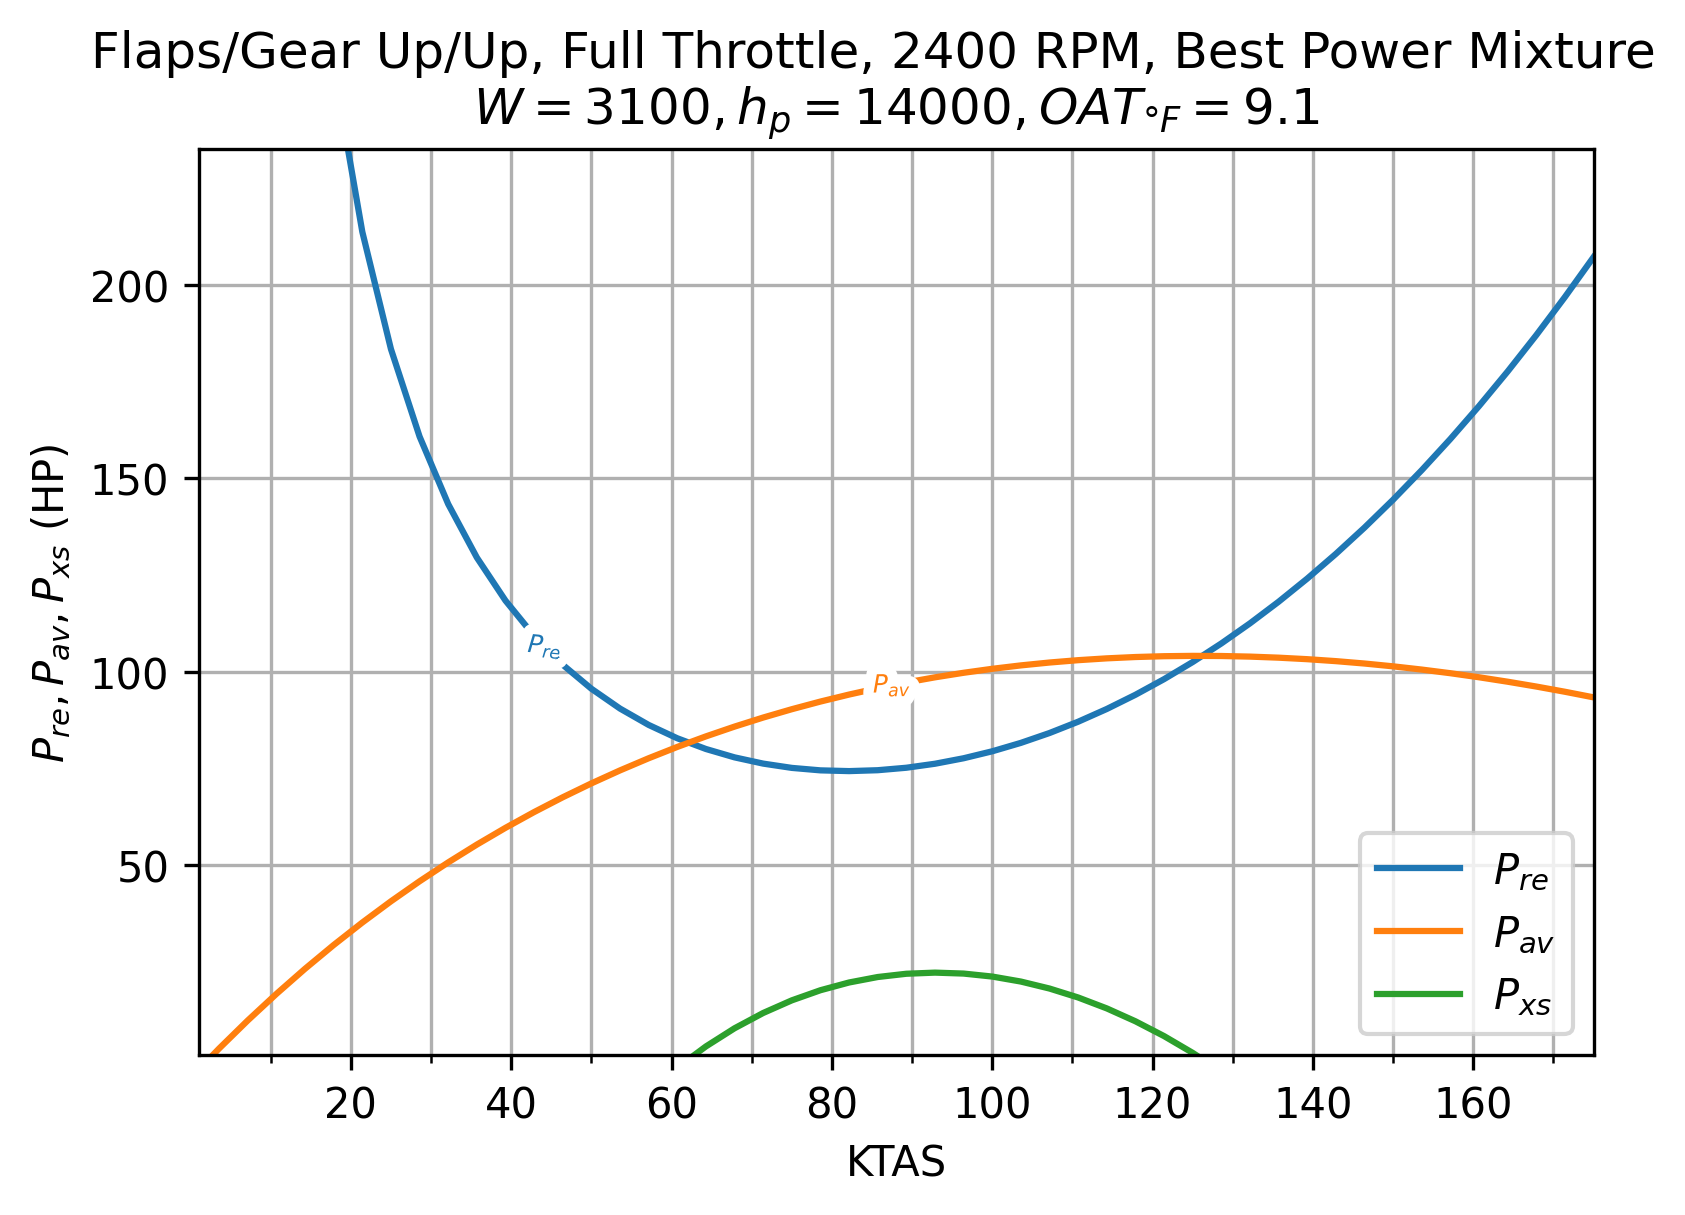

In [1535]:
def G(atmospheric_density, reference_wing_area, parasite_drag_coefficient):
    """Calculate composite bootstrap parameter :math:`G`."""
    return 0.5 * atmospheric_density * reference_wing_area * parasite_drag_coefficient


def H(
    gross_aircraft_weight,
    atmospheric_density,
    reference_wing_area,
    oswald_airplane_efficiency_factor,
    wing_aspect_ratio,
):
    """Calculate composite bootstrap parameter :math:`H`."""
    return (2 * gross_aircraft_weight ** 2) / (
        atmospheric_density
        * reference_wing_area
        * math.pi
        * oswald_airplane_efficiency_factor
        * wing_aspect_ratio
    )


G_calculated = G(
    OperationalParameters.atmospheric_density,
    DataPlate.reference_wing_area,
    DataPlate.parasite_drag_coefficient,
)

H_calculated = H(
    OperationalParameters.gross_aircraft_weight,
    OperationalParameters.atmospheric_density,
    DataPlate.reference_wing_area,
    DataPlate.airplane_efficiency_factor,
    DataPlate.wing_aspect_ratio,
)


def power_required(g, air_speed, h):
    """Determine power required :math:`P_{re}` to overcome the total drag force
    at air speed :math:`V`."""
    # $P_{re} = {GV}^3 + H/V$
    return g * air_speed ** 3 + h / air_speed


def power_available(air_speed, relative_atmospheric_density):
    eta = propeller_efficiency(
        DataPlate.z_ratio,
        propeller_advance_ratio(
            air_speed, OperationalParameters.propeller_rps, DataPlate.propeller_diameter
        ),
        propeller_power_coefficient(
            OperationalParameters.power,
            atmospheric_density(relative_atmospheric_density),
            OperationalParameters.propeller_rps,
            DataPlate.propeller_diameter,
        ),
        power_adjustment_factor_x(DataPlate.total_activity_factor),
    )

    return eta * OperationalParameters.power


def tas(cas, relative_atmospheric_density):
    return cas / math.sqrt(relative_atmospheric_density)


def cas(tas, relative_atmospheric_density):
    return math.sqrt(relative_atmospheric_density) * tas


# $V_{NE}$ for a C182RG is 175 KCAS
never_exceed_speed = 175  # tas(175)

fig, ax = plt.subplots()

resolution = 50

x = np.linspace(0, never_exceed_speed, resolution)
y = power_required(G_calculated, x / 0.5924838, H_calculated) / 550
ax.plot(x, y, label=r"$P_{re}$")

x = np.linspace(0, never_exceed_speed, resolution)
y = (
    power_available(x / 0.5924838, OperationalParameters.relative_atmospheric_density)
    / 550
)
ax.plot(x, y, label=r"$P_{av}$")

x = np.linspace(0, never_exceed_speed, resolution)
y = (
    power_available(x / 0.5924838, OperationalParameters.relative_atmospheric_density)
    / 550
) - (power_required(G_calculated, x / 0.5924838, H_calculated) / 550)
ax.plot(x, y, label=r"$P_{xs}$")

# ax.axvline(tas(54), linestyle="--", linewidth=".8", color="black", label="$V_{S_1}$")

labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

plt.suptitle(
    f"Flaps/Gear Up/Up, Full Throttle, {OperationalParameters.engine_rpm} RPM, Best Power Mixture"
)

ax.set(
    xlabel="KTAS",
    ylabel=r"$P_{re}, P_{av}, P_{xs}$ (HP)",
    title=f"$W = {OperationalParameters.gross_aircraft_weight}, h_p = {OperationalParameters.pressure_altitude}, {{OAT_{{\degree{{F}}}}}} = {OperationalParameters.oat_f}$",
)

ax.grid(True, which="both")

ax.xaxis.set_minor_locator(AutoMinorLocator((2)))

ax.set_xlim([1, never_exceed_speed])
ax.set_ylim([1, DataPlate.rated_full_throttle_engine_horsepower])

plt.legend()

plt.savefig(
    f"full_throttle_pre_pav_pxs_{OperationalParameters.engine_rpm}_{OperationalParameters.gross_aircraft_weight}_{OperationalParameters.pressure_altitude}_{OperationalParameters.oat_f}.jpg",
    format="jpeg",
)
plt.show()


In [1536]:
from tabulate import tabulate

# bsfc for Best Power Mixture in lbs./BHP/.hr.
bsfc = 0.460


kcas = np.arange(60, 120, 1)
ktas = tas(kcas, OperationalParameters.relative_atmospheric_density)
vt = ktas / 0.5924838

pre = power_required(G_calculated, vt, H_calculated)
thrust = power_available(vt, OperationalParameters.relative_atmospheric_density) / vt
drag = power_required(G_calculated, vt, H_calculated) / vt
excess_thrust = thrust - drag

eta = propeller_efficiency(
    DataPlate.z_ratio,
    propeller_advance_ratio(
        vt,
        OperationalParameters.propeller_rps,
        DataPlate.propeller_diameter,
    ),
    propeller_power_coefficient(
        OperationalParameters.power,
        OperationalParameters.atmospheric_density,
        OperationalParameters.propeller_rps,
        DataPlate.propeller_diameter,
    ),
    power_adjustment_factor_x(DataPlate.total_activity_factor),
)
h = 60 * excess_thrust * vt / OperationalParameters.gross_aircraft_weight
y = (180 / math.pi) * np.arcsin(
    excess_thrust / OperationalParameters.gross_aircraft_weight
)
pbhp = ((pre / eta) / DataPlate.rated_full_throttle_engine_power) * 100
gph = (bsfc * (pre / eta) / 550) / 6
mpg = ktas / gph

table = zip(kcas, ktas, eta, thrust, drag, h, y, pbhp, gph, mpg)


print(
    f"Flaps/Gear Up/Up, Full Throttle, {OperationalParameters.engine_rpm} RPM, Best Power Mixture"
)
print(
    f"$W = {OperationalParameters.gross_aircraft_weight}, h_p = {OperationalParameters.pressure_altitude}, {{OAT_{{\degree{{F}}}}}} = {OperationalParameters.oat_f}$",
)
print(
    tabulate(
        table,
        headers=[
            "KCAS",
            "KTAS",
            "η (Propulsive Efficiency)",
            "T (lb)",
            "D (lb)",
            "Rate of Climb (FPM)",
            "Flight Path Angle Correction (Deg)",
            "%bhp",
            "gph",
            "mpg",
        ],
        tablefmt="fancy_grid",
    )
)


Flaps/Gear Up/Up, Full Throttle, 2400 RPM, Best Power Mixture
$W = 3100, h_p = 14000, {OAT_{\degree{F}}} = 9.1$
╒════════╤══════════╤═════════════════════════════╤══════════╤══════════╤═══════════════════════╤══════════════════════════════════════╤═════════╤══════════╤══════════╕
│   KCAS │     KTAS │   η (Propulsive Efficiency) │   T (lb) │   D (lb) │   Rate of Climb (FPM) │   Flight Path Angle Correction (Deg) │    %bhp │      gph │      mpg │
╞════════╪══════════╪═════════════════════════════╪══════════╪══════════╪═══════════════════════╪══════════════════════════════════════╪═════════╪══════════╪══════════╡
│     60 │  74.4191 │                    0.635955 │  394.154 │  329.911 │             156.179   │                            1.18746   │ 50.4137 │  9.08287 │  8.19335 │
├────────┼──────────┼─────────────────────────────┼──────────┼──────────┼───────────────────────┼──────────────────────────────────────┼─────────┼──────────┼──────────┤
│     61 │  75.6595 │                    0.

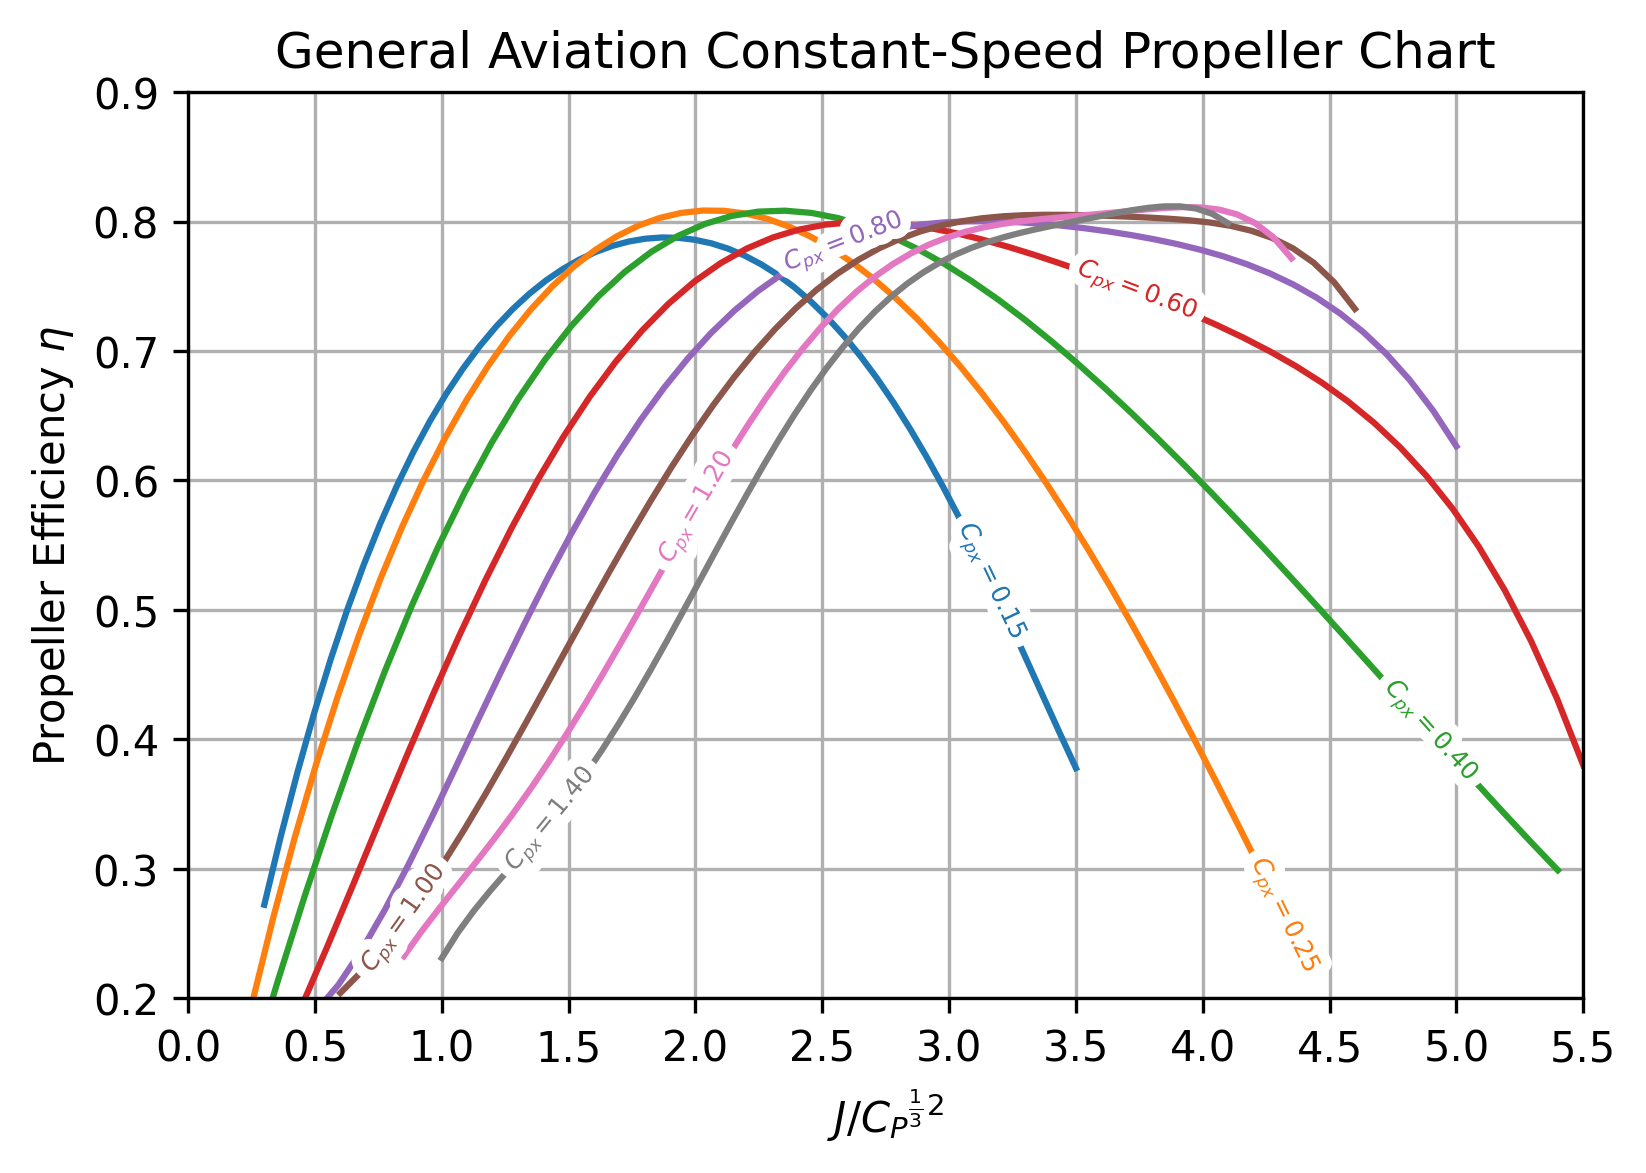

In [1537]:
fig, ax = plt.subplots()

from labellines import labelLines


def f(coefficients, x):
    return (
        (coefficients[6] * x ** 6)
        + (coefficients[5] * x ** 5)
        + (coefficients[4] * x ** 4)
        + (coefficients[3] * x ** 3)
        + (coefficients[2] * x ** 2)
        + (coefficients[1] * x)
        + coefficients[0]
    )


def plot_propeller_efficiency_curve(label, min, max, coefficients):
    x = np.linspace(min, max, 50)
    y = f(coefficients, x)

    ax.plot(x, y, label=label)


plot_propeller_efficiency_curve(
    r"$C_{px} = 0.15$",
    0.30,
    3.50,
    [
        -0.0272805419249278,
        1.15781894222425,
        -0.548923123012512,
        0.0385516502694899,
        0.064580555280077,
        -0.0263012433108758,
        0.00301741988065448,
    ],
)

plot_propeller_efficiency_curve(
    r"$C_{px} = 0.25$",
    0.25,
    4.40,
    [
        -0.0385029968953664,
        1.04613581578757,
        -0.485313329667262,
        0.130100232509281,
        -0.0273266101237454,
        0.00313901396067647,
        -0.000131566344754572,
    ],
)

plot_propeller_efficiency_curve(
    r"$C_{px} = 0.40$",
    0.25,
    5.40,
    [
        -0.026741905,
        0.7175824135,
        -0.08467335,
        -0.07445168,
        0.026437051,
        -0.003537565,
        0.000177733,
    ],
)

plot_propeller_efficiency_curve(
    r"$C_{px} = 0.60$",
    0.45,
    5.50,
    [
        0.0381002521517944,
        0.199522455590403,
        0.458898025445346,
        -0.3189927366795,
        0.0813578214054723,
        -0.00908380171181081,
        0.000350613125807782,
    ],
)

plot_propeller_efficiency_curve(
    r"$C_{px} = 0.80$",
    0.50,
    5.00,
    [
        0.251897476,
        -0.56166584,
        1.13905513,
        -0.60219333,
        0.144341736,
        -0.01619473,
        0.000664038,
    ],
)

plot_propeller_efficiency_curve(
    r"$C_{px} = 1.00$",
    0.60,
    4.60,
    [
        0.140144145675375,
        0.0716361297937569,
        -0.0573564176265628,
        0.276378945894403,
        -0.159843307010587,
        0.0342398462584903,
        -0.00257300278564554,
    ],
)

plot_propeller_efficiency_curve(
    r"$C_{px} = 1.20$",
    0.85,
    4.35,
    [
        -0.705604050000001,
        2.868232531,
        -3.651371295,
        2.487262933,
        -0.863421200000001,
        0.1464783315,
        -0.00968685500000001,
    ],
)

plot_propeller_efficiency_curve(
    r"$C_{px} = 1.40$",
    1.00,
    4.10,
    [
        -2.34053218393923,
        7.56393789714959,
        -9.02096499247491,
        5.55004513329438,
        -1.79377691748934,
        0.291020480453595,
        -0.0187431693125258,
    ],
)

labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

ax.set(
    xlabel=r"$J/C_P{}^\frac{1}{3}{}^2$",
    ylabel=r"Propeller Efficiency $\eta$",
    title="General Aviation Constant-Speed Propeller Chart",
)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

ax.grid(True, which="both")

ax.set_xlim([0.0, 5.5])
ax.set_ylim([0.2, 0.9])

plt.savefig("general_aviation_constant_speed_propeller_chart.jpg", format="jpeg")
plt.show()
